In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_location = "/workspace/HRV/탭넷/fonts/NanumGothic-Regular.ttf"
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [2]:
import sys
sys.path.append('/workspace/HRV')
from utils.imports import *
from utils.func import *
from utils.various_models import *
from utils.corr_vif import *
from utils.delete_feature import *
import itertools
from utils.figure import *
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score
from pytorch_tabnet.tab_model import TabNetClassifier
import json
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
import torch
#  GPU 및 PyTorch 최적화 설정
torch.set_num_threads(torch.get_num_threads())
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
os.environ["OMP_NUM_THREADS"] = str(torch.get_num_threads())
os.environ["MKL_NUM_THREADS"] = str(torch.get_num_threads())
os.environ["NUMEXPR_MAX_THREADS"] = str(torch.get_num_threads())
from IPython.display import display
import shap
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from 

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.1.2+cu121
12.1
True
1


In [4]:
another_target = ['PSS', 'AB' , 'CES', 'state_anx', 'BFI'] # FSS외 target 후보 변수
df = pd.read_csv('../../초반 코드/data1.csv')
df.columns = df.columns.str.replace(' ', '_')
df.drop(columns = '수진당시나이',inplace = True)
df.drop(columns = another_target, inplace = True)
print(df.columns)
df.drop(columns='피로도', inplace = True)
'''
cortisol 추가 시도 
해당 수치 없는 사람은 버리지 않고 mice 로 예측
'''
col_list = {'num_col': ['Age',  '자율신경 활성도',  '자율신경 균형도',  '스트레스 저항도',  '스트레스 지수',  '피로도',  '평균 심박동수',  '심장 안정도',  'Sdnn',  'Psi',  'Tp',  'Vlf',  'Lf',  'Hf',  'LfNorm',  'HfNorm',  'Lf/Hf',  'Rmssd',  'Apen',  'Srd',  'Tsrd',  'Tp(ln)',  'Vlf(ln)',  'Lf(ln)',  'Hf(ln)',  '수진당시나이',  '25-Hydroxy Vitamin D (Total)',  'Albumin',  'Free T4',  'GGT',  'GOT (AST)',  'GPT (ALT)',  'Glucose',  'Hb',  'HbA1c-NGSP',  'LDL-Cholesterol',  'TSH',  'TG',  'eGFR'],
 'cat_col': ['Sex', 'PSS', 'AB', 'FSS', 'CES', 'BFI'],
 'cat_col_ord': [],
 'label': ['state_anx'],
 'drop_col': ['ChartID',  'PersonalID',  '환자번호',  '측정센서',  '25-Hydroxy Vitamin D (D3/D2)',  '등록번호_확인',  'Date']}
res = pd.read_excel('../../초반 코드/HRV_Cortisol_241218.xlsx')
res_num = pd.read_excel('../../초반 코드/final_data.xlsx')
df['Chart_ID'] = res_num['ChartID']
df['Date'] = res_num['Date']
res_unique = res.drop_duplicates(subset=["환자번호", "검진 시행일자","검사 세부 항목명"], keep="first")
res_wide = res_unique.pivot(
    index=["환자번호", "검진 시행일자"],
    columns=["검사 세부 항목명"],
    values="검사결과"
).reset_index()
res_wide["Chart ID"] = res_wide.groupby("환자번호")["환자번호 <- 상부위장관 내시경(위) 결과지  <- 과별서식기본"].transform(lambda group: group.ffill().bfill())
columns = ["Chart ID"] + [col for col in res_wide.columns if col != "Chart ID"]  # 열 순서 정의
res_wide = res_wide[columns]
res_wide['Chart ID'] = res_wide['Chart ID'].astype('int64')
res_wide.columns = res_wide.columns.str.replace(' ', '_')
res_wide.columns = ['Chart_ID', '환자번호', '검진_시행일자','Cortisol(핵의학)','환자번호_<-_상부위장관_내시경(위)_결과지__<-_과별서식기본']
df['Date'] = pd.to_datetime(df['Date'])
merged_df = pd.merge(
    df, 
    res_wide[['Chart_ID', '검진_시행일자', 'Cortisol(핵의학)']], 
    left_on=['Chart_ID', 'Date'],
    right_on=['Chart_ID', '검진_시행일자'],
    how='left'  
)
merged_df.drop(columns = ['Date', 'Chart_ID','검진_시행일자'],inplace = True)
print(merged_df.shape)
col_list['num_col'].append('Cortisol(핵의학)')
nac = merged_df.isna().sum()
print(nac[nac > 0]) # nan값 없음
df = merged_df.copy()
blood = ['25-Hydroxy_Vitamin_D_(Total)','Albumin','Free_T4','GGT','GOT_(AST)','GPT_(ALT)','Glucose','Hb','HbA1c-NGSP','LDL-Cholesterol','TSH','TG']
df.drop(columns=blood, inplace = True)
print(df.columns)
num_cols=['Age','자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
      '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
      'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
      'Hf(ln)', 'eGFR','Cortisol(핵의학)']
cat_cols = ['Sex']
targets= ['BFI']
features = num_cols.copy()
df['Cortisol_missing'] = df['Cortisol(핵의학)'].isnull().astype(int) 

Index(['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '피로도',
       '평균_심박동수', '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm',
       'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)',
       'Lf(ln)', 'Hf(ln)', 'FSS', '25-Hydroxy_Vitamin_D_(Total)', 'Albumin',
       'Free_T4', 'GGT', 'GOT_(AST)', 'GPT_(ALT)', 'Glucose', 'Hb',
       'HbA1c-NGSP', 'LDL-Cholesterol', 'TSH', 'TG', 'eGFR'],
      dtype='object')
(336, 40)
Cortisol(핵의학)    108
dtype: int64
Index(['Age', 'Sex', '자율신경_활성도', '자율신경_균형도', '스트레스_저항도', '스트레스_지수', '평균_심박동수',
       '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf', 'LfNorm', 'HfNorm',
       'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd', 'Tp(ln)', 'Vlf(ln)', 'Lf(ln)',
       'Hf(ln)', 'FSS', 'eGFR', 'Cortisol(핵의학)'],
      dtype='object')


In [ ]:
target = 'FSS'
X = df.drop(columns=[target])
y = df[target].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

candidate_features = [
    'Age', 'Sex','자율신경_활성도', '자율신경_균형도',
    '스트레스_저항도', '스트레스_지수', '평균_심박동수',
    '심장_안정도', 'Sdnn', 'Psi', 'Tp', 'Vlf', 'Lf', 'Hf',
    'LfNorm', 'HfNorm', 'Lf/Hf', 'Rmssd', 'Apen', 'Srd', 'Tsrd',
    'Tp(ln)', 'Vlf(ln)', 'Lf(ln)', 'Hf(ln)', 'Cortisol(핵의학)'
]

# IterativeImputer 사용 (MICE 방식)
imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, 
                                    random_state=42, n_jobs=-1),
    max_iter=10,
    random_state=42
)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[candidate_features]),
                               columns=candidate_features,
                               index=X_train.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[candidate_features]),
                              columns=candidate_features,
                              index=X_test.index)

def evaluate_feature_subset(feature_subset, X_data, y_data, param, batch_size, virtual_batch_size, n_splits=5):
    """
    주어진 feature_subset에 대해 TabNetClassifier를 K-Fold CV로 학습하여 평균 AUC를 반환.
    """
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_idx, valid_idx in kf.split(X_data, y_data):
        X_train_k = X_data.iloc[train_idx][feature_subset].copy()
        X_valid_k = X_data.iloc[valid_idx][feature_subset].copy()
        y_train_k = y_data.iloc[train_idx].astype(int)
        y_valid_k = y_data.iloc[valid_idx].astype(int)
        
        scaler = StandardScaler()
        X_train_k = pd.DataFrame(scaler.fit_transform(X_train_k), 
                                 columns=feature_subset, index=X_train_k.index)
        X_valid_k = pd.DataFrame(scaler.transform(X_valid_k), 
                                 columns=feature_subset, index=X_valid_k.index)
        
        model = TabNetClassifier(
        n_d=param["n_d"],
        n_a=param["n_a"],
        n_steps=param["n_steps"],
        gamma=param["gamma"],
        lambda_sparse=param["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": param["optimizer_lr"]},
        mask_type=param["mask_type"],
        momentum=param["momentum"],
        device_name="cuda" if torch.cuda.is_available() else "cpu",
        verbose = 0
    )

        model.fit(
            X_train=X_train_k.values, y_train=y_train_k.values.ravel(),
            eval_set=[(X_valid_k.values, y_valid_k.values.ravel())],
            eval_metric=["auc"],
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            max_epochs=300, patience=200, 
        )

        
        y_pred = model.predict_proba(X_valid_k.values)[:, 1]
        auc_scores.append(roc_auc_score(y_valid_k, y_pred))
    
    return np.mean(auc_scores)


# 초기 TabNet 파라미터 및 하이퍼파라미터 설정
# 기본 파라미터 (피처 선택 평가용)
param =  {'n_d': 12, 'n_a': 10, 'learning_rate': 0.023951255499127366, 'gamma': 1.0704621124873812, 'lambda_sparse': 0.010256162748473083, 'momentum': 0.04087418023033583, 'n_steps': 10, 'optimizer_lr': 0.005918951335463648, 'batch_size': 37}
batch_size = param['batch_size']
virtual_batch_size = batch_size // 4
del param['batch_size']
param['mask_type'] = 'entmax'
param['device_name']="cuda" if torch.cuda.is_available() else "cpu"
param['verbose'] = 0

# Forward Feature Selection 진행
selected_features = []      # 현재 선택된 피처 집합
remaining_features = candidate_features.copy()
best_score = 0.0
improvement = True

print("Forward Feature Selection 시작:")
while improvement and remaining_features:
    improvement = False
    best_candidate = None
    best_candidate_score = best_score
    
    for feature in remaining_features:
        current_subset = selected_features + [feature]
        score = evaluate_feature_subset(current_subset, X_train_imputed, y_train, param, batch_size, virtual_batch_size, n_splits=5)
        print(f"평가 조합 {current_subset}: CV AUC = {score:.4f}")
        if score > best_candidate_score:
            best_candidate_score = score
            best_candidate = feature
            improvement = True
    
    if improvement and best_candidate is not None:
        selected_features.append(best_candidate)
        remaining_features.remove(best_candidate)
        best_score = best_candidate_score
        print(f"=> 피처 '{best_candidate}' 선택, 현재 조합: {selected_features}, CV AUC = {best_score:.4f}\n")
    else:
        break

print("최적 피처 조합:", selected_features)
print("최적 CV AUC:", best_score)
# 로깅 남겨서 진행함 -> ['Age', 'Cortisol(핵의학)', 'Vlf(ln)']가 선택됨

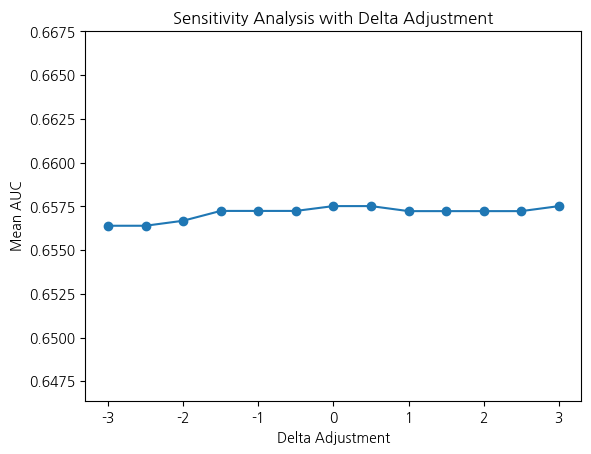

Delta adjustment AUC results: {-3: 0.6563891625615763, -2.5: 0.6563891625615763, -2: 0.6566748768472905, -1.5: 0.6572364532019705, -1.0: 0.6572364532019705, -0.5: 0.6572364532019705, 0: 0.6575123152709359, 0.5: 0.6575123152709359, 1.0: 0.6572249589490968, 1.5: 0.6572249589490968, 2: 0.6572249589490968, 2.5: 0.6572249589490968, 3: 0.6575106732348112}


In [ ]:
# 새로 선택된 피쳐조합에 대해서도 코르티솔 결측 예측에 대한 민감도 분석 수행
selected_feature = ['Age', 'Cortisol(핵의학)', 'Vlf(ln)']

target = 'FSS'
X = df.drop(columns=[target])
y = df[target].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, random_state=42,n_jobs=-1),
    max_iter=10,
    random_state=42
)

# Train 데이터에서 Imputer 학습 (fit_transform)
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[selected_feature ]),
                               columns=selected_feature ,
                               index=X_train.index)

# Test 데이터 변환 (transform)
X_test_imputed = pd.DataFrame(imputer.transform(X_test[selected_feature ]),
                              columns=selected_feature,
                              index=X_test.index)
X_train_imputed['Cortisol_missing'] = X_train['Cortisol(핵의학)'].isna().astype(int)
X_test_imputed['Cortisol_missing'] = X_test['Cortisol(핵의학)'].isna().astype(int)

# Delta Adjustment 적용 함수 (Train 데이터에서만 조정)
def apply_delta_adjustment(X, original_X, delta):
    X_adj = X.copy()
    missing_mask = original_X['Cortisol(핵의학)'].isna()  
    X_adj.loc[missing_mask, 'Cortisol(핵의학)'] += delta
    return X_adj

# Delta 값을 조정하여 민감도 분석 수행
delta_values = [-3,-2.5,-2,-1.5,-1.0, -0.5, 0, 0.5, 1.0,1.5,2,2.5,3] 
auc_results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for delta in delta_values:
    X_train_delta = apply_delta_adjustment(X_train_imputed, X_train, delta)

    aucs = []
    for train_idx, val_idx in skf.split(X_train_delta, y_train):
        X_train_cv, X_val_cv = X_train_delta.iloc[train_idx], X_train_delta.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        scaler = StandardScaler()
        X_train_cv = scaler.fit_transform(X_train_cv)
        X_val_cv = scaler.transform(X_val_cv)

        model = LogisticRegression(max_iter=10000, random_state=42,solver = 'newton-cg')  
        model.fit(X_train_cv, y_train_cv)
        y_pred = model.predict_proba(X_val_cv)[:, 1]
        aucs.append(roc_auc_score(y_val_cv, y_pred))
    
    auc_results[delta] = np.mean(aucs)

plt.plot(delta_values, list(auc_results.values()), marker='o')
plt.xlabel('Delta Adjustment')
plt.ylabel('Mean AUC')
plt.ylim(min(auc_results.values()) - 0.01, max(auc_results.values()) + 0.01)
plt.title('Sensitivity Analysis with Delta Adjustment')
plt.show()
print("Delta adjustment AUC results:", auc_results)

In [ ]:
# 최적 피처 조합에 대해 하이퍼파라미터 튜닝 
selected_feature = ['Age', 'Cortisol(핵의학)', 'Vlf(ln)']
print("\n하이퍼파라미터 튜닝 시작:")
target = 'FSS'
X = df.drop(columns=[target])
y = df[target].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, random_state=42,n_jobs=-1),
    max_iter=10,
    random_state=42
)

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[selected_feature ]),
                               columns=selected_feature ,
                               index=X_train.index)

X_test_imputed = pd.DataFrame(imputer.transform(X_test[selected_feature ]),
                              columns=selected_feature,
                              index=X_test.index)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

X_train_imputed = X_train_imputed[selected_feature]
X_test_imputed = X_test_imputed[selected_feature]

def objective(trial):
    params = {
        "n_d": trial.suggest_int("n_d", 2, 30),
        "n_a": trial.suggest_int("n_a", 2, 30),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, log=True), 
        "gamma": trial.suggest_float("gamma", 1.0, 1.5),
        "lambda_sparse": trial.suggest_float("lambda_sparse", 1e-6, 1e-1, log=True),
        "momentum": trial.suggest_float("momentum", 0.02, 0.3),
        "n_steps": trial.suggest_int("n_steps", 3, 10),
        "mask_type": "entmax",
        "optimizer_params": {"lr": trial.suggest_float("optimizer_lr", 0.001, 0.01, log=True)}
    }

    batch_size = trial.suggest_int("batch_size", 32, 60)
    virtual_batch_size =  batch_size // 4 

    auc_scores = []

    for train_index, valid_index in kf.split(X_train_imputed, y_train):
        X_train_k = X_train_imputed.iloc[train_index].copy()
        X_valid_k = X_train_imputed.iloc[valid_index].copy()
        y_train_k = y_train.iloc[train_index].astype(int)
        y_valid_k = y_train.iloc[valid_index].astype(int)
        
        scaler_kfold  = StandardScaler() 
        X_train_k[selected_feature] = scaler_kfold.fit_transform(X_train_k[selected_feature])
        X_valid_k[selected_feature] = scaler_kfold.transform(X_valid_k[selected_feature])

        model = TabNetClassifier(
            n_d=params["n_d"],
            n_a=params["n_a"],
            n_steps=params["n_steps"],
            gamma=params["gamma"],
            lambda_sparse=params["lambda_sparse"],
            optimizer_params=params["optimizer_params"],
            mask_type=params["mask_type"],
            momentum=params["momentum"],
            device_name="cuda" if torch.cuda.is_available() else "cpu",
            verbose = 0
        )

        model.fit(
            X_train=X_train_k.values, y_train=y_train_k.values.ravel(),
            eval_set=[(X_valid_k.values, y_valid_k.values.ravel())],
            eval_metric=["auc"],
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            max_epochs=300, patience=200, 
        )

        y_proba_k = model.predict_proba(X_valid_k.values)[:, 1]

        auc = roc_auc_score(y_valid_k, y_proba_k)
        auc_scores.append(auc)
        
    val_auc = np.mean(auc_scores)

    return val_auc

# Optuna 실행
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials = 50)  

# 최적 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

In [7]:
param = study.best_params # {'n_d': 30, 'n_a': 13, 'learning_rate': 0.015019865281286005, 'gamma': 1.4581791101473804, 'lambda_sparse': 8.183880863882647e-06, 'momentum': 0.2844187635172765, 'n_steps': 9, 'optimizer_lr': 0.004086867557305667, 'batch_size': 49}
batch_size = param['batch_size']
virtual_batch_size = batch_size // 4
del param['batch_size']
param['mask_type'] = 'entmax'
param['device_name']="cuda" if torch.cuda.is_available() else "cpu"
param['verbose'] = 0

In [9]:
selected_feature = ['Age', 'Cortisol(핵의학)', 'Vlf(ln)']

target = 'FSS'
X = df.drop(columns=[target])
y = df[target].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=5, random_state=42,n_jobs=-1),
    max_iter=10,
    random_state=42
)

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train[selected_feature ]),
                               columns=selected_feature ,
                               index=X_train.index)

X_test_imputed = pd.DataFrame(imputer.transform(X_test[selected_feature ]),
                              columns=selected_feature,
                              index=X_test.index)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

auc_scores = []
X_train_imputed = X_train_imputed[selected_feature]
X_test_imputed = X_test_imputed[selected_feature]

for train_index, valid_index in kf.split(X_train_imputed, y_train):
    X_train_k = X_train_imputed.iloc[train_index].copy()
    X_valid_k = X_train_imputed.iloc[valid_index].copy()
    y_train_k = y_train.iloc[train_index].astype(int)
    y_valid_k = y_train.iloc[valid_index].astype(int)
    
    scaler_kfold  = StandardScaler() 
    X_train_k[selected_feature] = scaler_kfold.fit_transform(X_train_k[selected_feature])
    X_valid_k[selected_feature] = scaler_kfold.transform(X_valid_k[selected_feature])


    model = TabNetClassifier(
        n_d=param["n_d"],
        n_a=param["n_a"],
        n_steps=param["n_steps"],
        gamma=param["gamma"],
        lambda_sparse=param["lambda_sparse"],
            optimizer_fn=torch.optim.Adam,  
    optimizer_params={"lr": param["optimizer_lr"]},  
        mask_type=param["mask_type"],
        momentum=param["momentum"],
        device_name="cuda" if torch.cuda.is_available() else "cpu",
        verbose = 0
    )

    model.fit(
        X_train=X_train_k.values, y_train=y_train_k.values.ravel(),
        eval_set=[(X_valid_k.values, y_valid_k.values.ravel())],
        eval_metric=["auc"],
        batch_size=batch_size,
        virtual_batch_size=virtual_batch_size,
        max_epochs=300, patience=200, 
    )

    y_proba_k = model.predict_proba(X_valid_k.values)[:, 1]

    auc = roc_auc_score(y_valid_k, y_proba_k)
    auc_scores.append(auc)
    
val_auc = np.mean(auc_scores)
    

X_train_imputed_all = X_train_imputed.copy()
X_test_imputed_all = X_test_imputed.copy()

scaler = StandardScaler() 
X_train_imputed_all[selected_feature] = scaler.fit_transform(X_train_imputed_all[selected_feature])
X_test_imputed_all[selected_feature] = scaler.transform(X_test_imputed_all[selected_feature])    
model = TabNetClassifier(
    n_d=param["n_d"],
    n_a=param["n_a"],
    n_steps=param["n_steps"],
    gamma=param["gamma"],
    lambda_sparse=param["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,  
    optimizer_params={"lr": param["optimizer_lr"]}, 
    mask_type=param["mask_type"],
    momentum=param["momentum"],
    device_name="cuda" if torch.cuda.is_available() else "cpu",
    verbose = 0
)
model.fit(X_train = X_train_imputed_all.values, y_train = y_train.values.ravel(), 
            eval_set=[(X_test_imputed_all.values, y_test.values.ravel())], 
            eval_metric=["auc"], 
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            max_epochs=300, patience=200,
            )
y_proba = model.predict_proba(X_test_imputed_all.values)[:, 1]
test_auc = roc_auc_score(y_test, y_proba)
print(f"Test AUC: {BRIGHT_YELLOW}{test_auc}{BRIGHT_END}")
print(f"Validation AUC: {BRIGHT_RED}{val_auc}{BRIGHT_END}")


Early stopping occurred at epoch 262 with best_epoch = 62 and best_val_0_auc = 0.72966

Early stopping occurred at epoch 223 with best_epoch = 23 and best_val_0_auc = 0.73793

Early stopping occurred at epoch 228 with best_epoch = 28 and best_val_0_auc = 0.68

Early stopping occurred at epoch 257 with best_epoch = 57 and best_val_0_auc = 0.80429
Stop training because you reached max_epochs = 300 with best_epoch = 272 and best_val_0_auc = 0.80747

Early stopping occurred at epoch 235 with best_epoch = 35 and best_val_0_auc = 0.75955
Test AUC: 0.759548611111111
Validation AUC: 0.7518686371100165


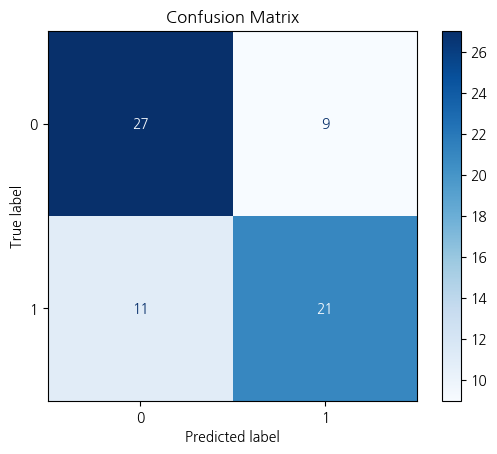

오차행렬:
 [[27  9]
 [11 21]]

정확도: 0.7059
정밀도: 0.7000
재현율: 0.6562
F1: 0.6774


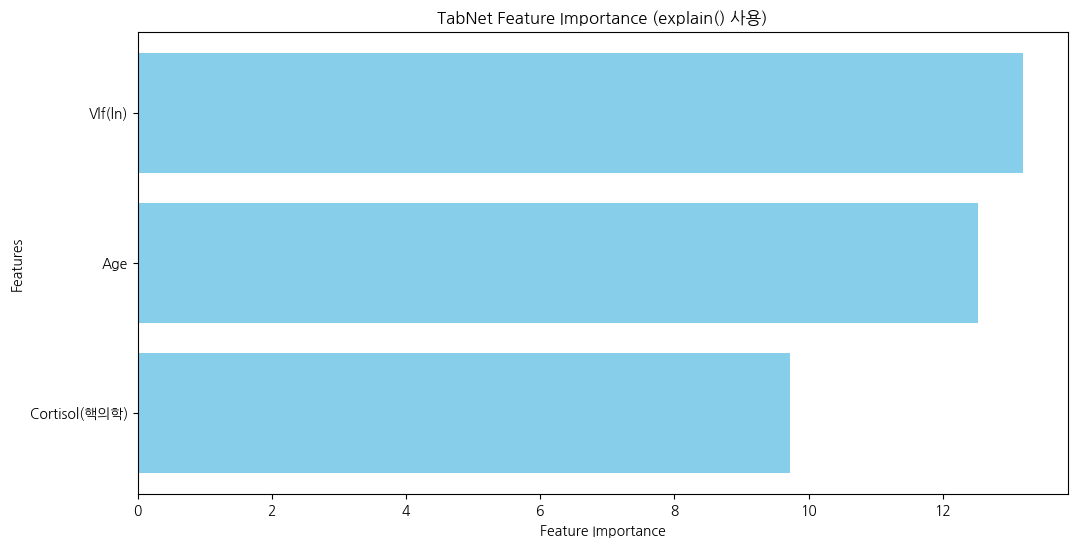

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_imputed_all.values)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
get_clf_eval(y_test, y_pred)
# TabNet Feature Importance 계산
explain_matrix, masks = model.explain(X_test_imputed_all.values)
# 중요도가 높은 순서대로 정렬
feature_importance = explain_matrix.mean(axis=0)  # 평균 중요도 계산
sorted_idx = np.argsort(feature_importance)[::-1]  # 내림차순 정렬
sorted_features = X_train_imputed_all.columns[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# 시각화
plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_importance, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("TabNet Feature Importance (explain() 사용)")
plt.gca().invert_yaxis()  
plt.show()
# TabNet의 Feature Importance 값은 모델이 예측을 수행하는 과정에서 해당 변수를 얼마나 자주 사용했는지를 측정한 것
# 자주 사용된다고 해서 반드시 중요한 변수라고 단정할 수는 없음
# 특정 Feature가 자주 선택되지만 실제로 성능 향상에 기여하지 않는다면?
# 그 Feature가 중요한 것이 아닐 수도 있음
# 단순히 모델이 자주 활용했을 뿐, 실제 예측력에는 영향이 적을 수도 있음
# TabNet Feature Importance만으로는 실제 예측력에 대한 기여도를 알 수 없음
# 그러므로 SHAP 분석을 함께 활용하는 것이 중요

ExactExplainer explainer: 69it [00:48,  1.40it/s]                        


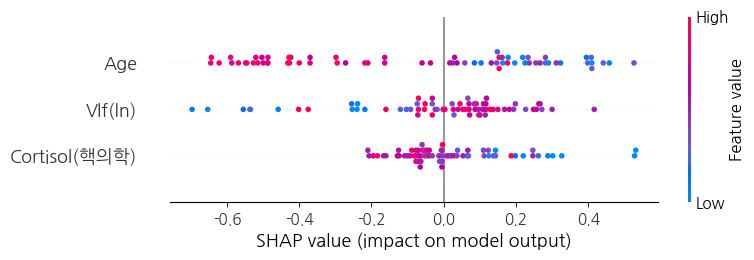

,Feature,Mean_Abs_SHAP
0,Age,0.318799
2,Vlf(ln),0.170956
1,Cortisol(핵의학),0.113529


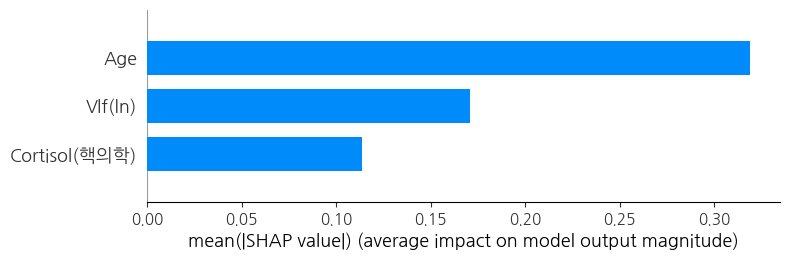

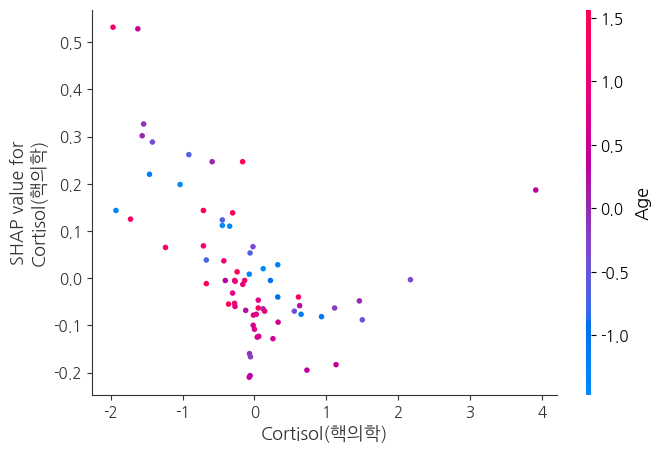

In [14]:
# SHAP은 모델이 각 Feature의 예측값에 미치는 영향을 수량적으로 분석할 수 있음
# SHAP Summary Plot에서 높은 Feature가 진짜 중요한 변수
# TabNet Feature Importance가 높지만 SHAP에서 영향이 적다면, 중요하지 않을 수도 있음

explainer = shap.Explainer(model.predict, X_train_imputed_all.values)
shap_values = explainer(X_test_imputed_all.values)

shap.summary_plot(shap_values, X_test_imputed_all, feature_names=X_train_imputed_all.columns)

mean_shap = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_train_imputed_all.columns,
    'Mean_Abs_SHAP': mean_shap
}).sort_values(by='Mean_Abs_SHAP', ascending=False)

display(importance_df)

shap.summary_plot(shap_values, X_test_imputed_all, plot_type = 'bar', 
                  feature_names=X_test_imputed_all.columns)
# SHAP 값에 접근할 때 .values 속성 사용
shap.dependence_plot(
    "Cortisol(핵의학)",
    shap_values.values,  
    X_test_imputed_all,
    feature_names=X_train_imputed_all.columns,
)
from IPython.display import HTML
shap.initjs()
force_plot = shap.force_plot(shap_values.base_values , shap_values.values, 
                X_train_imputed_all,)
HTML(f"<div style='background-color:white;'>{shap.getjs() + force_plot.html()}</div>")

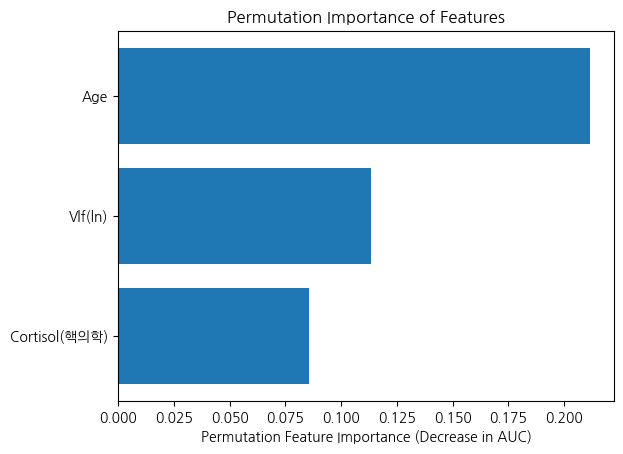

In [15]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    model, 
    X_test_imputed_all.values, 
    y_test, 
    scoring='roc_auc', 
    n_repeats=10, 
    random_state=42
)

sorted_idx = result.importances_mean.argsort()
plt.barh(
    np.array(X_test_imputed_all.columns)[sorted_idx], 
    result.importances_mean[sorted_idx]
)
plt.xlabel("Permutation Feature Importance (Decrease in AUC)")
plt.title("Permutation Importance of Features")
plt.show()


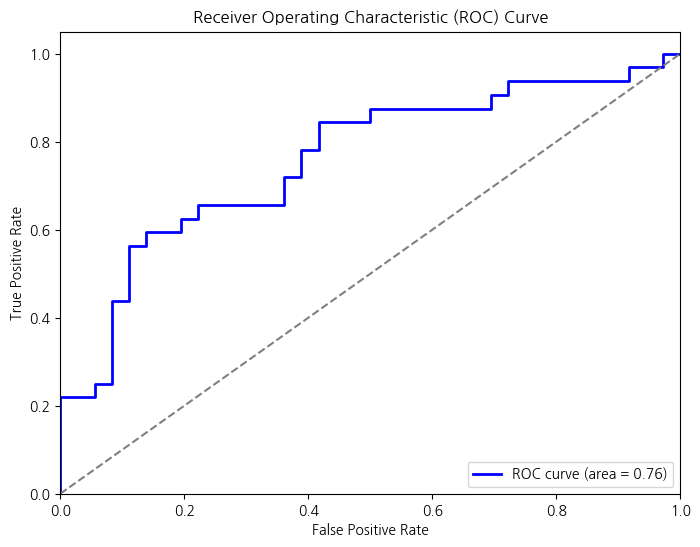

In [17]:
from sklearn.metrics import roc_curve, auc

# 실제 값과 예측 확률
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()
